In [13]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, average_precision_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

In [14]:
match=pd.read_csv("matches.xls")
delivery=pd.read_csv("deliveries.xls")

C:\Users\Kundan Mourya\AppData\Local\Temp\ipykernel_21772\1147082433.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=match_results, x='winner', y='win_margin', ci=None, palette='viridis')


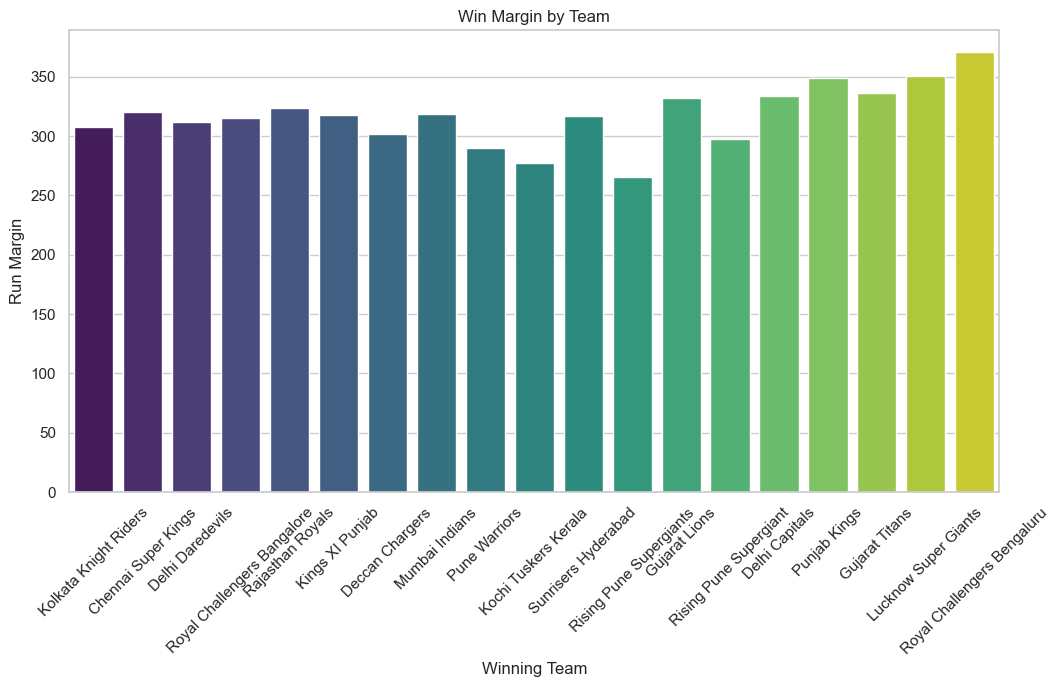

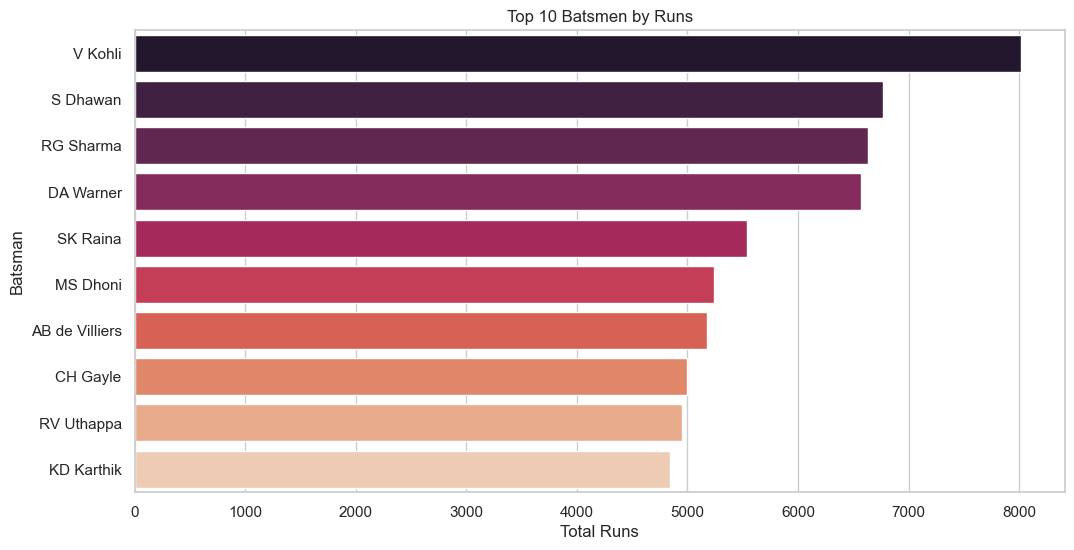

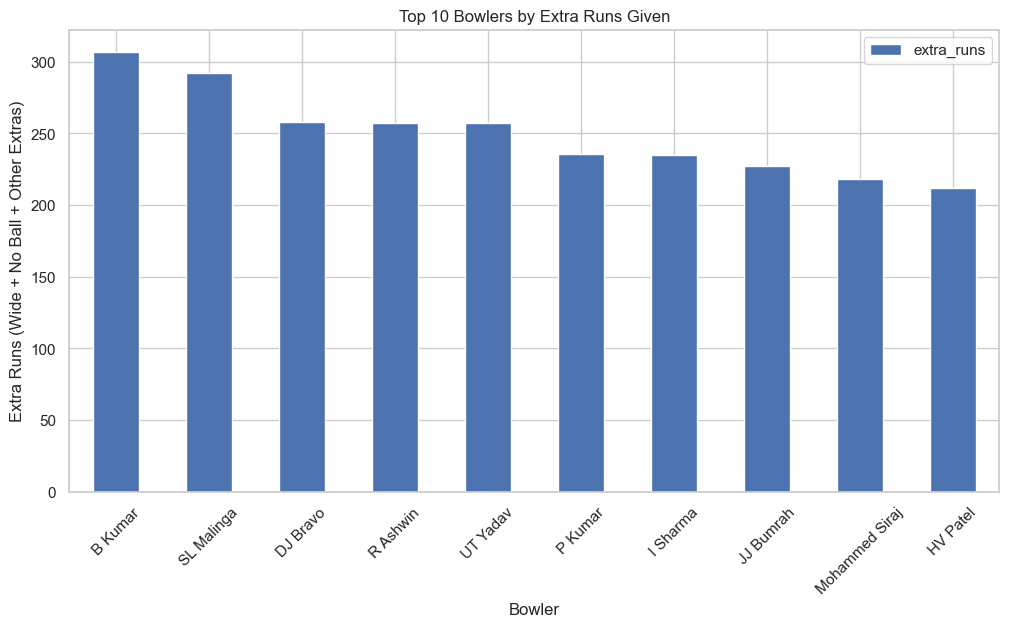

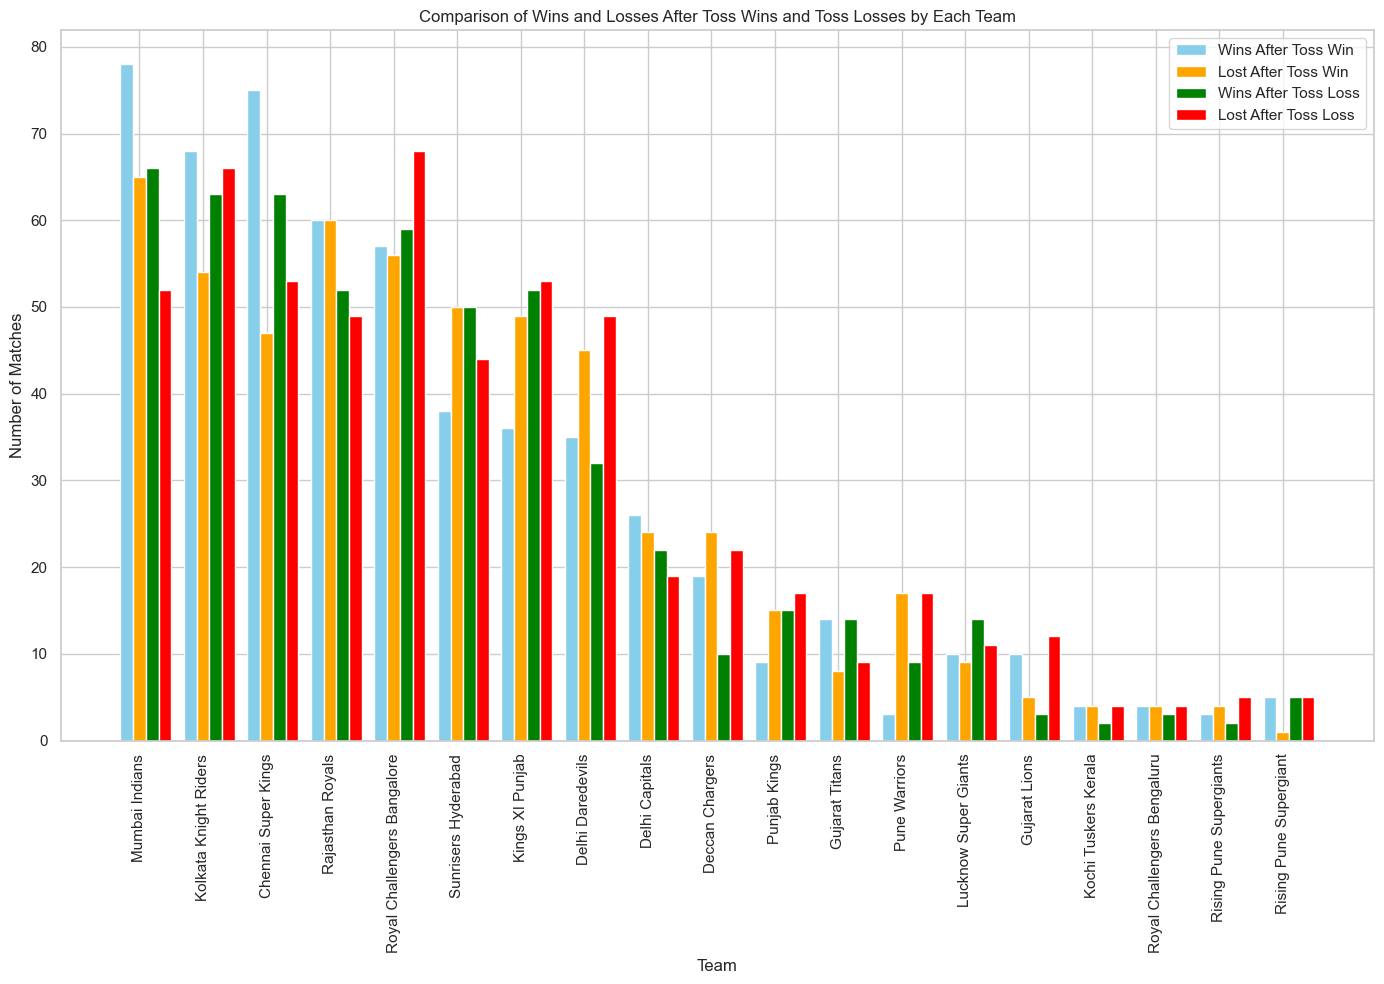

In [15]:
file1 =pd.read_csv("deliveries.xls")
file2 = pd.read_csv("matches.xls")
file2.rename(columns={'id': 'match_id'}, inplace=True)

# Merge the data on 'match_id'
merged_data = pd.merge(file1, file2, on='match_id', how='inner')

# Set up Seaborn style for better-looking plots
sns.set(style="whitegrid")

# 1. **Match Insights**: Winning team and margin analysis
def match_winning_margin():
    match_results = merged_data.groupby('match_id').agg({
        'winner': 'first',
        'team1': 'first',
        'team2': 'first',
        'total_runs': 'sum'
    }).reset_index()
    
    match_results['win_margin'] = match_results['total_runs'] - match_results.groupby('match_id')['total_runs'].shift().fillna(0)
    match_results = match_results.dropna()
    
    # Plot win margin by team
    plt.figure(figsize=(12, 6))
    sns.barplot(data=match_results, x='winner', y='win_margin', ci=None, palette='viridis')
    plt.title('Win Margin by Team')
    plt.xlabel('Winning Team')
    plt.ylabel('Run Margin')
    plt.xticks(rotation=45)
    plt.show()

# 2. **Player Performance**: Batsman total runs
def batsman_performance():
    batsman_data = merged_data.groupby('batter')['batsman_runs'].sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=batsman_data.values, y=batsman_data.index, palette="rocket")
    plt.title('Top 10 Batsmen by Runs')
    plt.xlabel('Total Runs')
    plt.ylabel('Batsman')
    plt.show()

# 3. **Bowling Analysis**: Wide, no-ball, and extra runs analysis
def bowling_discipline():
    bowling_data = merged_data.groupby('bowler').agg({
        #'wide_runs': 'sum',
        #'noball_runs': 'sum',
        'extra_runs': 'sum'
    }).sort_values(by='extra_runs', ascending=False).head(10)
    
    bowling_data.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Top 10 Bowlers by Extra Runs Given')
    plt.xlabel('Bowler')
    plt.ylabel('Extra Runs (Wide + No Ball + Other Extras)')
    plt.xticks(rotation=45)
    plt.show()

# 4. **Impact of Toss Decision**: Toss decision vs match outcome
def toss_analysis():
    # Load the CSV file for toss analysis
    df = pd.read_csv("matches.xls")

    # Calculate total toss wins by each team
    toss_wins = df['toss_winner'].value_counts().reset_index()
    toss_wins.columns = ['team', 'toss_wins']

    # Calculate wins after winning the toss
    wins_after_toss_win = df[df['toss_winner'] == df['winner']]['toss_winner'].value_counts().reset_index()
    wins_after_toss_win.columns = ['team', 'wins_after_toss_win']

    # Calculate total toss losses by each team
    df['toss_lost'] = df.apply(lambda row: row['team1'] if row['toss_winner'] == row['team2'] else row['team2'], axis=1)
    toss_losses = df['toss_lost'].value_counts().reset_index()
    toss_losses.columns = ['team', 'toss_losses']

    # Calculate wins after losing the toss
    wins_after_toss_loss = df[df['toss_lost'] == df['winner']]['toss_lost'].value_counts().reset_index()
    wins_after_toss_loss.columns = ['team', 'wins_after_toss_loss']

    # Merge all results into a single DataFrame
    result = toss_wins.merge(wins_after_toss_win, on='team', how='left')
    result = result.merge(toss_losses, on='team', how='left')
    result = result.merge(wins_after_toss_loss, on='team', how='left')
    result.fillna(0, inplace=True)  # Replace NaN with 0

    # Convert values to integers
    result[['toss_wins', 'wins_after_toss_win', 'toss_losses', 'wins_after_toss_loss']] = result[['toss_wins', 'wins_after_toss_win', 'toss_losses', 'wins_after_toss_loss']].astype(int)

    # Calculate losses after winning and losing the toss
    result['lost_after_toss_win'] = result['toss_wins'] - result['wins_after_toss_win']
    result['lost_after_toss_loss'] = result['toss_losses'] - result['wins_after_toss_loss']

    # Display the tab

    # Plotting the side-by-side bar chart for toss wins
    plt.figure(figsize=(14, 10))

    # Set positions and width for the bars
    x = np.arange(len(result['team']))
    width = 0.2

    # Create bars for wins and losses after toss wins and losses
    plt.bar(x - width, result['wins_after_toss_win'], width, color='skyblue', label='Wins After Toss Win')
    plt.bar(x, result['lost_after_toss_win'], width, color='orange', label='Lost After Toss Win')
    plt.bar(x + width, result['wins_after_toss_loss'], width, color='green', label='Wins After Toss Loss')
    plt.bar(x + 2*width, result['lost_after_toss_loss'], width, color='red', label='Lost After Toss Loss')

    # Add labels and title
    plt.xlabel('Team')
    plt.ylabel('Number of Matches')
    plt.title('Comparison of Wins and Losses After Toss Wins and Toss Losses by Each Team')
    plt.xticks(x, result['team'], rotation=90)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call functions to display each analysis and graph
match_winning_margin()
batsman_performance()
bowling_discipline()
toss_analysis()


In [16]:
total_score_df=delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()

C:\Users\Kundan Mourya\AppData\Local\Temp\ipykernel_21772\2630719186.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_score_df=delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()


In [17]:
delivery

match_id  inning           batting_team                 bowling_team  \
0         335982       1  Kolkata Knight Riders  Royal Challengers Bangalore   
1         335982       1  Kolkata Knight Riders  Royal Challengers Bangalore   
2         335982       1  Kolkata Knight Riders  Royal Challengers Bangalore   
3         335982       1  Kolkata Knight Riders  Royal Challengers Bangalore   
4         335982       1  Kolkata Knight Riders  Royal Challengers Bangalore   
...          ...     ...                    ...                          ...   
260915   1426312       2  Kolkata Knight Riders          Sunrisers Hyderabad   
260916   1426312       2  Kolkata Knight Riders          Sunrisers Hyderabad   
260917   1426312       2  Kolkata Knight Riders          Sunrisers Hyderabad   
260918   1426312       2  Kolkata Knight Riders          Sunrisers Hyderabad   
260919   1426312       2  Kolkata Knight Riders          Sunrisers Hyderabad   

        over  ball       batter         bowler  non_striker  batsman_runs  \
0          0     1   SC Ganguly        P Kumar  BB McCullum             0   
1          0     2  BB McCullum        P Kumar   SC Ganguly             0   
2          0     3  BB McCullum        P Kumar   SC Ganguly             0   
3          0     4  BB McCullum        P Kumar   SC Ganguly             0   
4          0     5  BB McCullum        P Kumar   SC Ganguly             0   
...      ...   ...          ...            ...          ...           ...   
260915     9     5      SS Iyer     AK Markram      VR Iyer             1   
260916     9     6      VR Iyer     AK Markram      SS Iyer             1   
260917    10     1      VR Iyer  Shahbaz Ahmed      SS Iyer             1   
260918    10     2      SS Iyer  Shahbaz Ahmed      VR Iyer             1   
260919    10     3      VR Iyer  Shahbaz Ahmed      SS Iyer             1   

        extra_runs  total_runs extras_type  is_wicket player_dismissed  \
0                1           1     legbyes          0              NaN   
1                0           0         NaN          0              NaN   
2                1           1       wides          0              NaN   
3                0           0         NaN          0              NaN   
4                0           0         NaN          0              NaN   
...            ...         ...         ...        ...              ...   
260915           0           1         NaN          0              NaN   
260916           0           1         NaN          0              NaN   
260917           0           1         NaN          0              NaN   
260918           0           1         NaN          0              NaN   
260919           0           1         NaN          0              NaN   

       dismissal_kind fielder  
0                 NaN     NaN  
1                 NaN     NaN  
2                 NaN     NaN  
3                 NaN     NaN  
4                 NaN     NaN  
...               ...     ...  
260915            NaN     NaN  
260916            NaN     NaN  
260917            NaN     NaN  
260918            NaN     NaN  
260919            NaN     NaN  

[260920 rows x 17 columns]

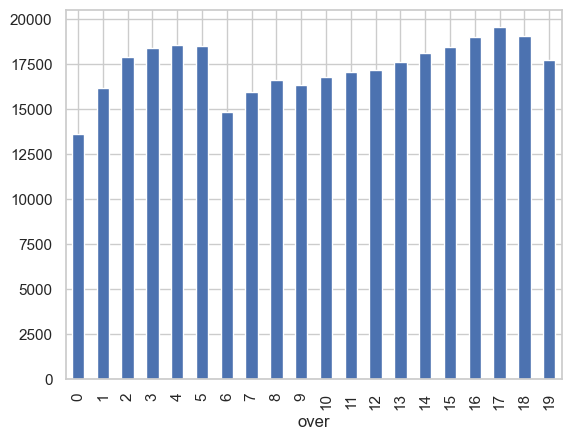

In [18]:
delivery.groupby(['over'])['total_runs'].sum().plot.bar()
plt.show()

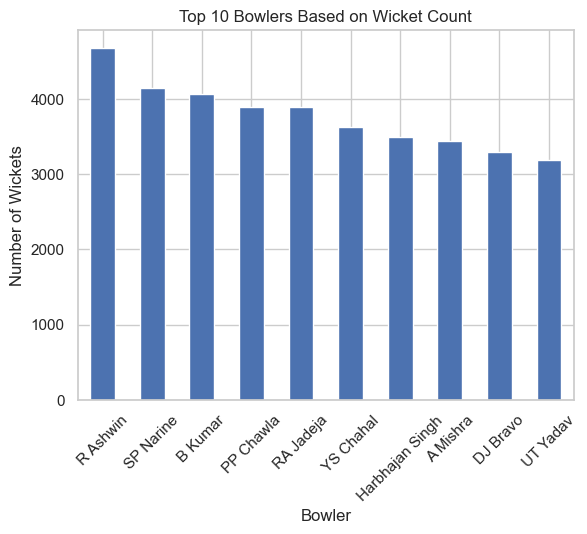

In [19]:
# Get the top 10 bowlers based on the count of is_wicket
top_10_bowlers = (delivery.groupby(['bowler'])['is_wicket'].count()).nlargest(10)

# Plot the bar chart
top_10_bowlers.plot.bar()
plt.title('Top 10 Bowlers Based on Wicket Count')
plt.xlabel('Bowler')
plt.ylabel('Number of Wickets')
plt.xticks(rotation=45)
plt.show()

In [20]:
total_score_df=total_score_df[total_score_df['inning']==1]

In [21]:
match_df=match.merge(total_score_df[['match_id','total_runs']], left_on = 'id', right_on='match_id')

In [22]:
match_df.columns

Index(['id', 'season', 'city', 'date', 'match_type', 'player_of_match',
       'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
       'method', 'umpire1', 'umpire2', 'match_id', 'total_runs'],
      dtype='object')

In [23]:
match_df['team1'].unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [24]:
teams = [
    'Royal Challengers Bengaluru',
    'Mumbai Indians',
    'Kolkata Knight Riders',
    'Chennai Super Kings',
    'Delhi Capitals',
    'Rajasthan Royals', 
    'Punjab Kings',
    'Sunrisers Hyderabad',
    'Lucknow Super Giants',
    'Gujarat Titans' 
]

In [25]:
match_df['team1']= match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2']= match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1']= match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2	']= match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

match_df['team1']= match_df['team1'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')
match_df['team2']= match_df['team2'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')

match_df['team1']= match_df['team1'].str.replace('Kings XI Punjab','Punjab Kings')
match_df['team2']= match_df['team2'].str.replace('Kings XI Punjab','Punjab Kings')

In [26]:
match_df['team1'].unique()

array(['Royal Challengers Bengaluru', 'Punjab Kings', 'Delhi Capitals',
       'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
       'Sunrisers Hyderabad', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Gujarat Lions',
       'Rising Pune Supergiants', 'Rising Pune Supergiant',
       'Lucknow Super Giants', 'Gujarat Titans'], dtype=object)

In [27]:
match_df=match_df[match_df['team1'].isin(teams)]
match_df=match_df[match_df['team2'].isin(teams)]

In [28]:
match_df['team2'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Royal Challengers Bengaluru', 'Punjab Kings', 'Delhi Capitals',
       'Mumbai Indians', 'Sunrisers Hyderabad', 'Gujarat Titans',
       'Lucknow Super Giants'], dtype=object)

In [29]:
match_df.shape

(947, 23)

In [30]:
column = match_df.columns
column

Index(['id', 'season', 'city', 'date', 'match_type', 'player_of_match',
       'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
       'method', 'umpire1', 'umpire2', 'match_id', 'total_runs', 'team2\t'],
      dtype='object')

In [31]:
delivery_df= match_df.merge(delivery, left_on='id', right_on='match_id', how='inner')

In [32]:
delivery_df = delivery_df[delivery_df['inning']==2]

In [33]:
delivery_df['total_runs_y'] = pd.to_numeric(delivery_df['total_runs_y'], errors='coerce')
delivery_df['current_score'] = delivery_df.groupby('id')['total_runs_y'].cumsum()

In [34]:
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']

In [35]:
delivery_df['balls_left']= 120 - (delivery_df['over']*6 + delivery_df['ball'])

In [36]:
#delivery_df['player_dismissed'].info()

In [37]:
delivery_df['player_dismissed']=delivery_df['player_dismissed'].fillna(0).apply(lambda x:0 if x==0 else 1)

In [38]:
def calculate_wickets_left(group):
    group['wickets'] = group['player_dismissed'].cumsum()  # Cumulative sum of wickets lost
    group['wickets_left'] = 10 - group['wickets']  # Wickets left
    return group

# Apply the function to calculate wickets left for each match
delivery_df= delivery_df.groupby('id', group_keys=False).apply(calculate_wickets_left)

In [39]:
import pandas as pd
delivery_df['date'] = pd.to_datetime(delivery_df['date'])

filtered_df = delivery_df#[(delivery_df['date'].dt.year >= 2020) & (delivery_df['date'].dt.year <= 2024)]

filtered_df.columns


Index(['id', 'season', 'city', 'date', 'match_type', 'player_of_match',
       'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
       'method', 'umpire1', 'umpire2', 'match_id_x', 'total_runs_x', 'team2\t',
       'match_id_y', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs_y', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder', 'current_score', 'runs_left', 'balls_left',
       'wickets', 'wickets_left'],
      dtype='object')

In [40]:
filtered_df['crr']=(filtered_df['current_score']*6)/(120-filtered_df['balls_left'])
filtered_df['rrr']=(filtered_df['runs_left']*6)/filtered_df['balls_left']

In [41]:
columns_to_keep = ['batting_team', 'date','bowling_team', 'toss_winner', 'toss_decision', 'city', 'balls_left', 'wickets_left', 'total_runs_x', 'current_score','runs_left','crr','rrr','winner']  
filtered_df = filtered_df[columns_to_keep]

In [42]:
filtered_df = filtered_df.rename(columns={'balls_left': 'ball_left', 'wickets_left': 'wicket_left', 'total_runs_x': 'first_inning_run', 'current_score': 'current_runs', 'runs_left': 'run_left', })

In [43]:
ipl=filtered_df

In [44]:
def function(text):
    if text['batting_team']==text['winner']:
        return 1 
    else :
        return 0

In [45]:
ipl['winner']=ipl.apply(function,axis=1)

In [46]:
ipl=ipl.drop(columns=['city'])

In [47]:
ipl=ipl.dropna()

In [48]:
ipl=ipl[ipl['ball_left']!=0]

In [49]:
all_current_teams=['Sunrisers Hyderabad', 'Mumbai Indians',
        'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Capitals', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Sunrisers Hyderabad',
       'Delhi Capitals']

In [50]:
ipl=ipl[ipl['batting_team'].isin(all_current_teams)]
ipl=ipl[ipl['bowling_team'].isin(all_current_teams)]

In [51]:
ipl['toss_winner']=ipl['toss_winner'].str.replace('Delhi Daredevils','Delhi Capitals')
ipl['toss_winner']=ipl['toss_winner'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

In [52]:
ipl=ipl[ipl['ball_left']!=0]

In [53]:
df_train = ipl[(ipl['date'].dt.year <= 2020)]
df_test = ipl[(ipl['date'].dt.year >= 2020)]

df_train=df_train.drop(columns=['date'])
df_test=df_test.drop(columns=['date'])

In [54]:
X_train=df_train.iloc[:,:-1]
X_test=df_test.iloc[:,:-1]

In [55]:
X_train_1=X_train

In [56]:
y_train=df_train['winner']
y_test=df_test['winner']

In [57]:
trf = ColumnTransformer([
    ('trf', OneHotEncoder(drop='first'), ['batting_team', 'bowling_team', 'toss_winner', 'toss_decision'])
], remainder='passthrough')
X_train, X_test = trf.fit_transform(X_train), trf.transform(X_test)


In [58]:
feature_names = trf.get_feature_names_out()
#feature_names

In [59]:
def calculate_auc_roc(model, X_test, y_test):
    # Get predicted probabilities for each class
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probability for the positive class
    auc_roc = roc_auc_score(y_test, y_pred_prob)  # Calculate AUC-ROC score
    return auc_roc

In [60]:
from sklearn.metrics import roc_auc_score
lr = LogisticRegression()
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 300, 400, 500]
}
tscv = TimeSeriesSplit(n_splits=10)

# Perform grid search to find the best parameters
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, scoring='accuracy', cv=tscv, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

# Best parameters and best score on cross-validation
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Cross-Validation Score for Logistic Regression:", grid_search_lr.best_score_)

# Accuracy on each fold with the best estimator
lr_accuracies = cross_val_score(grid_search_lr.best_estimator_, X_train, y_train, cv=tscv, scoring='accuracy')
print("Logistic Regression Accuracies for each fold:", lr_accuracies)
print("Mean Accuracy of Logistic Regression:", np.mean(lr_accuracies))


lr_f1_scores = cross_val_score(grid_search_lr.best_estimator_, X_train, y_train, cv=tscv, scoring='f1')
print("Logistic Regression F1 Scores for each fold:", lr_f1_scores)
print("Mean F1 Score of Logistic Regression:", np.mean(lr_f1_scores))


# AUC-ROC score on each fold with the best estimator
lr_auc_roc_scores = cross_val_score(grid_search_lr.best_estimator_, X_train, y_train, cv=tscv, scoring='roc_auc')
print("Logistic Regression AUC-ROC Scores for each fold:", lr_auc_roc_scores)
print("Mean AUC-ROC of Logistic Regression:", np.mean(lr_auc_roc_scores))

# Test accuracy using the best parameters on test data
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Test Accuracy of the Best Logistic Regression Model:", accuracy_lr)
auc_roc_lr = round(calculate_auc_roc(best_lr_model, X_test, y_test), 2)

C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters for Logistic Regression: {'C': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}
Best Cross-Validation Score for Logistic Regression: 0.7632350106034316


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression Accuracies for each fold: [0.72662425 0.81665703 0.78716021 0.76094081 0.76229034 0.77173703
 0.74918064 0.69635628 0.7854251  0.77597841]
Mean Accuracy of Logistic Regression: 0.7632350106034316


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression F1 Scores for each fold: [0.72959573 0.81246303 0.82414782 0.78344394 0.76302133 0.77635059
 0.75242626 0.74031327 0.77401015 0.79323843]
Mean F1 Score of Logistic Regression: 0.7749010550639099


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression AUC-ROC Scores for each fold: [0.85967129 0.89464366 0.85610113 0.79936339 0.85894097 0.86043392
 0.82644308 0.79936984 0.87073486 0.87901368]
Mean AUC-ROC of Logistic Regression: 0.8504715810375313
Test Accuracy of the Best Logistic Regression Model: 0.8057294383585464


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
import numpy as np

# Logistic Regression model
lr = LogisticRegression()

# Parameter grid with L2 regularization
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2'],  # Adding L2 regularization
    'max_iter': [100, 200, 300, 400, 500]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Perform grid search to find the best parameters
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, scoring='accuracy', cv=tscv, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

# Best parameters and best score on cross-validation
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Cross-Validation Score for Logistic Regression:", grid_search_lr.best_score_)

# Accuracy on each fold with the best estimator
lr_accuracies = cross_val_score(grid_search_lr.best_estimator_, X_train, y_train, cv=tscv, scoring='accuracy')
print("Logistic Regression Accuracies for each fold:", lr_accuracies)
print("Mean Accuracy of Logistic Regression:", np.mean(lr_accuracies))

# F1 Score on each fold with the best estimator
lr_f1_scores = cross_val_score(grid_search_lr.best_estimator_, X_train, y_train, cv=tscv, scoring='f1')
print("Logistic Regression F1 Scores for each fold:", lr_f1_scores)
print("Mean F1 Score of Logistic Regression:", np.mean(lr_f1_scores))

# AUC-ROC score on each fold with the best estimator
lr_auc_roc_scores = cross_val_score(grid_search_lr.best_estimator_, X_train, y_train, cv=tscv, scoring='roc_auc')
print("Logistic Regression AUC-ROC Scores for each fold:", lr_auc_roc_scores)
print("Mean AUC-ROC of Logistic Regression:", np.mean(lr_auc_roc_scores))

# Test accuracy using the best parameters on test data


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters for Logistic Regression: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score for Logistic Regression: 0.7632350106034316


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression Accuracies for each fold: [0.72662425 0.81665703 0.78716021 0.76094081 0.76229034 0.77173703
 0.74918064 0.69635628 0.7854251  0.77597841]
Mean Accuracy of Logistic Regression: 0.7632350106034316


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression F1 Scores for each fold: [0.72959573 0.81246303 0.82414782 0.78344394 0.76302133 0.77635059
 0.75242626 0.74031327 0.77401015 0.79323843]
Mean F1 Score of Logistic Regression: 0.7749010550639099


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression AUC-ROC Scores for each fold: [0.85967129 0.89464366 0.85610113 0.79936339 0.85894097 0.86043392
 0.82644308 0.79936984 0.87073486 0.87901368]
Mean AUC-ROC of Logistic Regression: 0.8504715810375313


C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
best_lr_modell2 = grid_search_lr.best_estimator_
y_pred_lr = best_lr_modell2.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Test Accuracy of the Best Logistic Regression Model:", accuracy_lr)

# AUC-ROC for test data
auc_roc_lr = round(roc_auc_score(y_test, best_lr_model.predict_proba(X_test)[:, 1]), 2)
print("Test AUC-ROC of the Best Logistic Regression Model:", auc_roc_lr)


Test Accuracy of the Best Logistic Regression Model: 0.8057294383585464
Test AUC-ROC of the Best Logistic Regression Model: 0.89


Test AUC-ROC of the Best Logistic Regression Model: 0.8938010410041501


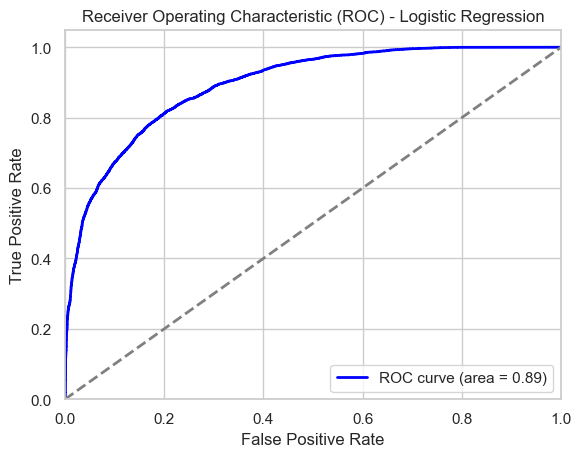

In [52]:

# Get the predicted probabilities for the positive class
y_pred_proba_lr = best_lr_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print("Test AUC-ROC of the Best Logistic Regression Model:", roc_auc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [53]:
df_train

batting_team           bowling_team  \
124     Royal Challengers Bangalore  Kolkata Knight Riders   
125     Royal Challengers Bangalore  Kolkata Knight Riders   
126     Royal Challengers Bangalore  Kolkata Knight Riders   
127     Royal Challengers Bangalore  Kolkata Knight Riders   
128     Royal Challengers Bangalore  Kolkata Knight Riders   
...                             ...                    ...   
158687               Mumbai Indians         Delhi Capitals   
158688               Mumbai Indians         Delhi Capitals   
158689               Mumbai Indians         Delhi Capitals   
158690               Mumbai Indians         Delhi Capitals   
158691               Mumbai Indians         Delhi Capitals   

                        toss_winner toss_decision  ball_left  wicket_left  \
124     Royal Challengers Bangalore         field        119           10   
125     Royal Challengers Bangalore         field        118           10   
126     Royal Challengers Bangalore         field        117           10   
127     Royal Challengers Bangalore         field        116           10   
128     Royal Challengers Bangalore         field        115           10   
...                             ...           ...        ...          ...   
158687               Delhi Capitals           bat         12            6   
158688               Delhi Capitals           bat         11            6   
158689               Delhi Capitals           bat         10            6   
158690               Delhi Capitals           bat          9            5   
158691               Delhi Capitals           bat          8            5   

        first_inning_run  current_runs  run_left       crr        rrr  winner  
124                  222             1       221  6.000000  11.142857       0  
125                  222             2       220  6.000000  11.186441       0  
126                  222             2       220  4.000000  11.282051       0  
127                  222             3       219  4.500000  11.327586       0  
128                  222             4       218  4.800000  11.373913       0  
...                  ...           ...       ...       ...        ...     ...  
158687               156           154         2  8.555556   1.000000       1  
158688               156           155         1  8.532110   0.545455       1  
158689               156           156         0  8.509091   0.000000       1  
158690               156           156         0  8.432432   0.000000       1  
158691               156           157        -1  8.410714  -0.750000       1  

[57062 rows x 12 columns]

In [54]:
coefficients = best_lr_modell2.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

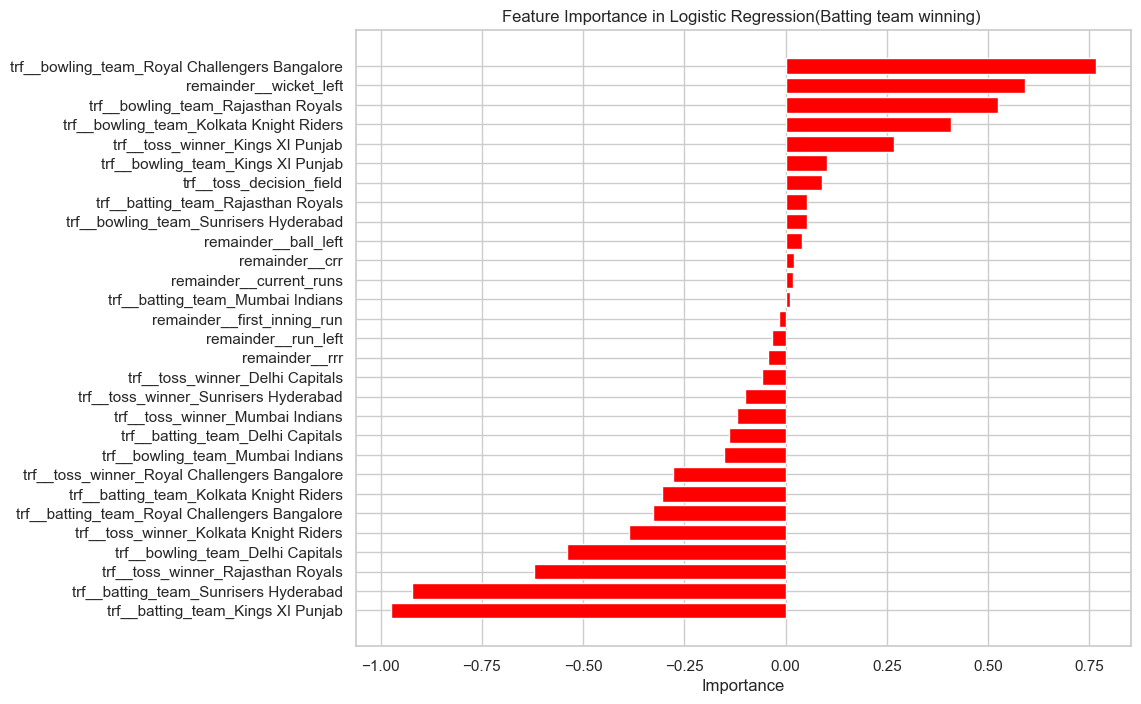

In [55]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='red')
plt.xlabel('Importance')
plt.title('Feature Importance in Logistic Regression(Batting team winning) ')
plt.gca().invert_yaxis()
plt.show()


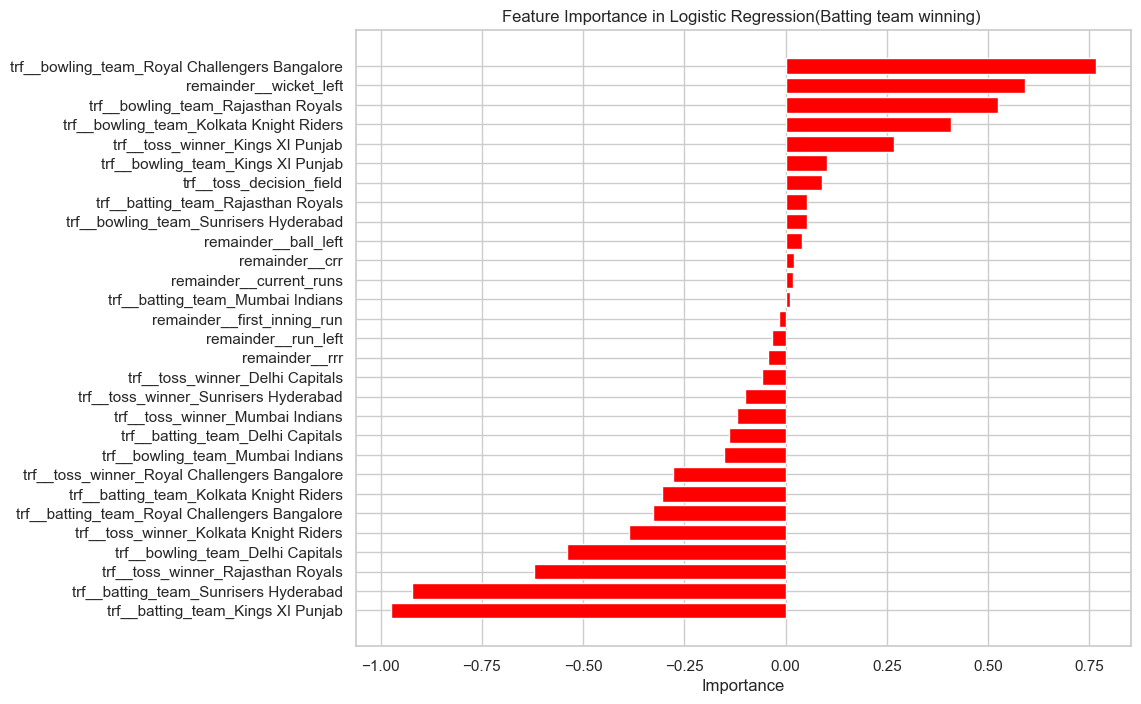

In [56]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='red')
plt.xlabel('Importance')
plt.title('Feature Importance in Logistic Regression(Batting team winning) ')
plt.gca().invert_yaxis()
plt.show()


In [57]:
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}
tscv = TimeSeriesSplit(n_splits=10)

# Perform grid search to find the best parameters
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, scoring='accuracy', cv=tscv, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Best parameters and best score on cross-validation
#print("Best Parameters for KNN:", grid_search_knn.best_params_)
#print("Best Cross-Validation Score for KNN:", grid_search_knn.best_score_)

# Accuracy on each fold with the best estimator
knn_accuracies = cross_val_score(grid_search_knn.best_estimator_, X_train, y_train, cv=tscv, scoring='accuracy')
#print("KNN Accuracies for each fold:", knn_accuracies)
#print("Mean Accuracy of KNN:", np.mean(knn_accuracies))


#knn_accuracies = cross_val_score(grid_search_knn.best_estimator_, X_train, y_train, cv=tscv, scoring='accuracy')
print("Logistic Regression Accuracies for each fold:", knn_accuracies)
print("Mean Accuracy of Logistic Regression:", np.mean(knn_accuracies))


knn_f1_scores = cross_val_score(grid_search_knn.best_estimator_, X_train, y_train, cv=tscv, scoring='f1')
print("Logistic Regression F1 Scores for each fold:", knn_f1_scores)
print("Mean F1 Score of Logistic Regression:", np.mean(knn_f1_scores))


# AUC-ROC score on each fold with the best estimator
knn_auc_roc_scores = cross_val_score(grid_search_knn.best_estimator_, X_train, y_train, cv=tscv, scoring='roc_auc')
print("Logistic Regression AUC-ROC Scores for each fold:", knn_auc_roc_scores)
print("Mean AUC-ROC of Logistic Regression:", np.mean(knn_auc_roc_scores))


# Test accuracy using the best parameters on test data
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
#print("Test Accuracy of the Best KNN Model:", accuracy_knn)
auc_roc_knn = round(calculate_auc_roc(best_knn_model, X_test, y_test), 2)

Logistic Regression Accuracies for each fold: [0.69982649 0.75149412 0.72488915 0.68690958 0.72334683 0.68768074
 0.70291112 0.67514941 0.75727781 0.76576056]
Mean Accuracy of Logistic Regression: 0.7175245806824754
Logistic Regression F1 Scores for each fold: [0.71404959 0.75091787 0.76995002 0.71205674 0.7326253  0.68977403
 0.71319561 0.72914322 0.75337904 0.79112945]
Mean F1 Score of Logistic Regression: 0.7356220879213097
Logistic Regression AUC-ROC Scores for each fold: [0.73880186 0.81508482 0.77804241 0.74785606 0.81286777 0.77601732
 0.77940284 0.74878729 0.83741711 0.83917869]
Mean AUC-ROC of Logistic Regression: 0.7873456173616039


Test AUC-ROC of the Best KNN Model: 0.8690927872938151


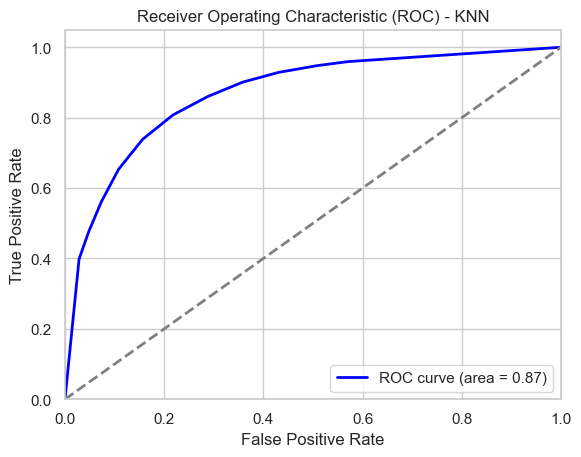

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_pred_proba_knn = best_knn_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_knn)

# Calculate the AUC
roc_auc_knn = auc(fpr, tpr)
print("Test AUC-ROC of the Best KNN Model:", roc_auc_knn)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - KNN')
plt.legend(loc="lower right")
plt.show()


In [59]:
dt = DecisionTreeClassifier()
param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
tscv = TimeSeriesSplit(n_splits=10)

# Perform grid search to find the best parameters
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, scoring='accuracy', cv=tscv, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Best parameters and best score on cross-validation
#print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)
#print("Best Cross-Validation Score for Decision Tree:", grid_search_dt.best_score_)

# Accuracy on each fold with the best estimator
dt_accuracies = cross_val_score(grid_search_dt.best_estimator_, X_train, y_train, cv=tscv, scoring='accuracy')
#print("Decision Tree Accuracies for each fold:", dt_accuracies)
#print("Mean Accuracy of Decision Tree:", np.mean(dt_accuracies))

print("Logistic Regression Accuracies for each fold:", dt_accuracies)
print("Mean Accuracy of Logistic Regression:", np.mean(dt_accuracies))


dt_f1_scores = cross_val_score(grid_search_dt.best_estimator_, X_train, y_train, cv=tscv, scoring='f1')
print("Logistic Regression F1 Scores for each fold:", dt_f1_scores)
print("Mean F1 Score of Logistic Regression:", np.mean(dt_f1_scores))


# AUC-ROC score on each fold with the best estimator
dt_auc_roc_scores = cross_val_score(grid_search_dt.best_estimator_, X_train, y_train, cv=tscv, scoring='roc_auc')
print("Logistic Regression AUC-ROC Scores for each fold:", dt_auc_roc_scores)
print("Mean AUC-ROC of Logistic Regression:", np.mean(dt_auc_roc_scores))

# Test accuracy using the best parameters on test data
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
#print("Test Accuracy of the Best Decision Tree Model:", accuracy_dt)
auc_roc_dt = round(calculate_auc_roc(best_dt_model, X_test, y_test), 2)

Logistic Regression Accuracies for each fold: [0.61557741 0.73298631 0.74339695 0.69134374 0.68208984 0.73838442
 0.68401774 0.71351456 0.71332177 0.76711008]
Mean Accuracy of Logistic Regression: 0.7081742818584924
Logistic Regression F1 Scores for each fold: [0.6008807  0.7425172  0.79121569 0.70466704 0.65494873 0.77288703
 0.71078172 0.75821673 0.72283318 0.80585021]
Mean F1 Score of Logistic Regression: 0.7264798218268976
Logistic Regression AUC-ROC Scores for each fold: [0.6090092  0.77895147 0.78351537 0.74588601 0.77322027 0.80708572
 0.76633038 0.81212325 0.78101294 0.85093422]
Mean AUC-ROC of Logistic Regression: 0.7708068815019709


Test AUC-ROC of the Best Decision Tree Model: 0.8738288431044547


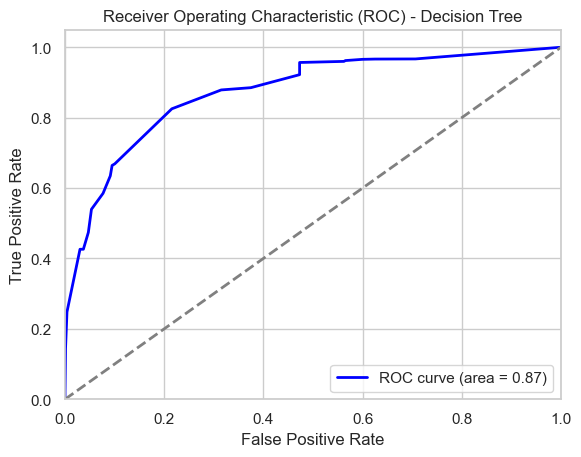

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_dt)

# Calculate the AUC
roc_auc_dt = auc(fpr, tpr)
print("Test AUC-ROC of the Best Decision Tree Model:", roc_auc_dt)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc="lower right")
plt.show()


In [61]:
feature_importance=best_dt_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_names,'Importance': feature_importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

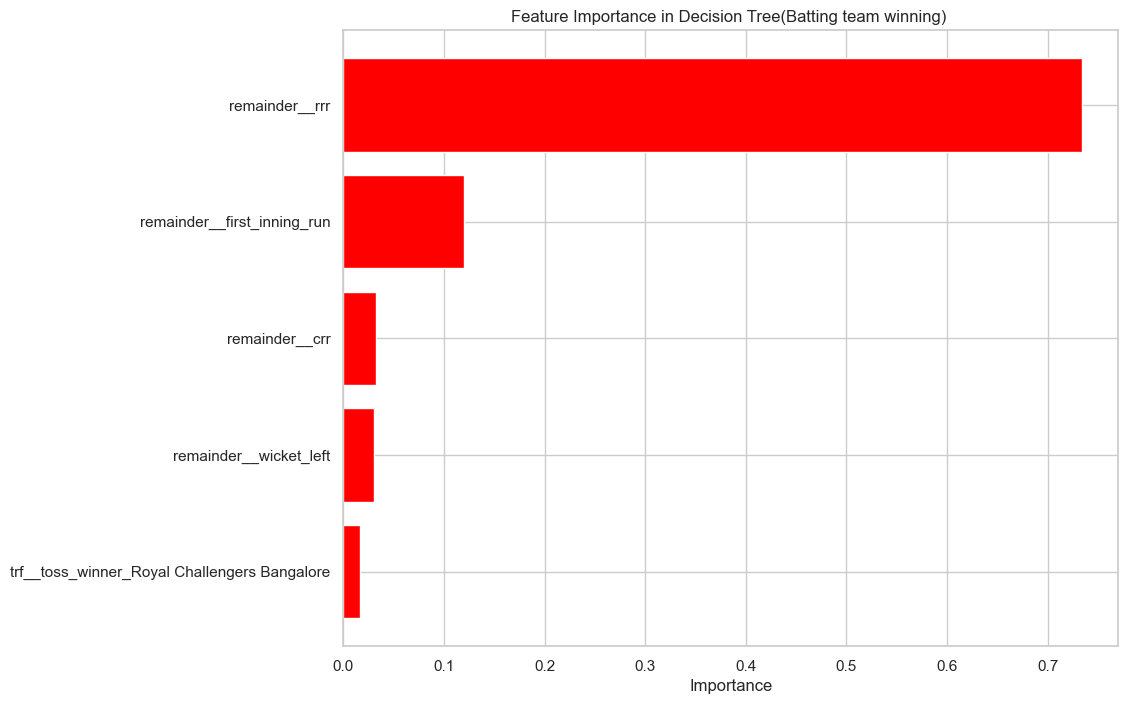

In [62]:
plt.figure(figsize=(10, 8))
feature_importance=feature_importance[:5]
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='red')
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree(Batting team winning) ')
plt.gca().invert_yaxis()
plt.show()


In [63]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
tscv = TimeSeriesSplit(n_splits=10)

# Perform grid search to find the best parameters
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='accuracy', cv=tscv, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score on cross-validation
#print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
#print("Best Cross-Validation Score for Random Forest:", grid_search_rf.best_score_)

# Accuracy on each fold with the best estimator
rf_accuracies = cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=tscv, scoring='accuracy')
#print("Random Forest Accuracies for each fold:", rf_accuracies)
#print("Mean Accuracy of Random Forest:", np.mean(rf_accuracies))


print("Logistic Regression Accuracies for each fold:", rf_accuracies)
print("Mean Accuracy of Logistic Regression:", np.mean(rf_accuracies))


rf_f1_scores = cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=tscv, scoring='f1')
print("Logistic Regression F1 Scores for each fold:", rf_f1_scores)
print("Mean F1 Score of Logistic Regression:", np.mean(rf_f1_scores))


# AUC-ROC score on each fold with the best estimator
rf_auc_roc_scores = cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=tscv, scoring='roc_auc')
print("Logistic Regression AUC-ROC Scores for each fold:", rf_auc_roc_scores)
print("Mean AUC-ROC of Logistic Regression:", np.mean(rf_auc_roc_scores))

# Test accuracy using the best parameters on test data
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
#print("Test Accuracy of the Best Random Forest Model:", accuracy_rf)
auc_roc_rf = round(calculate_auc_roc(best_rf_model, X_test, y_test), 2)

Logistic Regression Accuracies for each fold: [0.71756314 0.8264893  0.74937343 0.72450357 0.75053017 0.79024484
 0.71544245 0.72161172 0.76479661 0.79140158]
Mean Accuracy of Logistic Regression: 0.7551956815114709
Logistic Regression F1 Scores for each fold: [0.73212653 0.82462977 0.78412488 0.74694528 0.7532418  0.78029079
 0.72957127 0.75933333 0.76664116 0.81523224]
Mean F1 Score of Logistic Regression: 0.769213706148156
Logistic Regression AUC-ROC Scores for each fold: [0.76009946 0.90251467 0.82098077 0.77942625 0.85540581 0.88952174
 0.79570349 0.80043636 0.87501468 0.87015259]
Mean AUC-ROC of Logistic Regression: 0.8349255815635676


Test AUC-ROC of the Best Random Forest Model: 0.8989052321748551


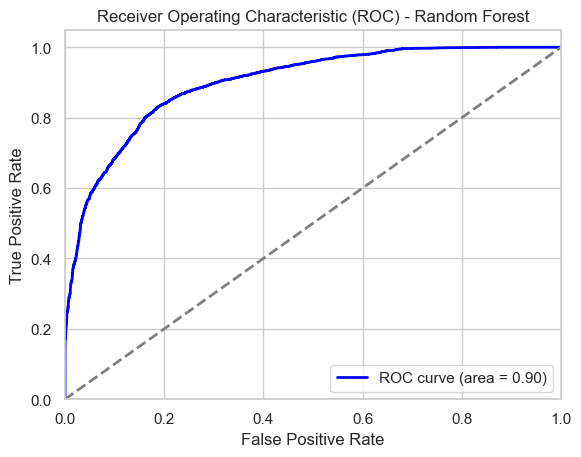

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)

# Calculate the AUC
roc_auc_rf = auc(fpr, tpr)
print("Test AUC-ROC of the Best Random Forest Model:", roc_auc_rf)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.show()


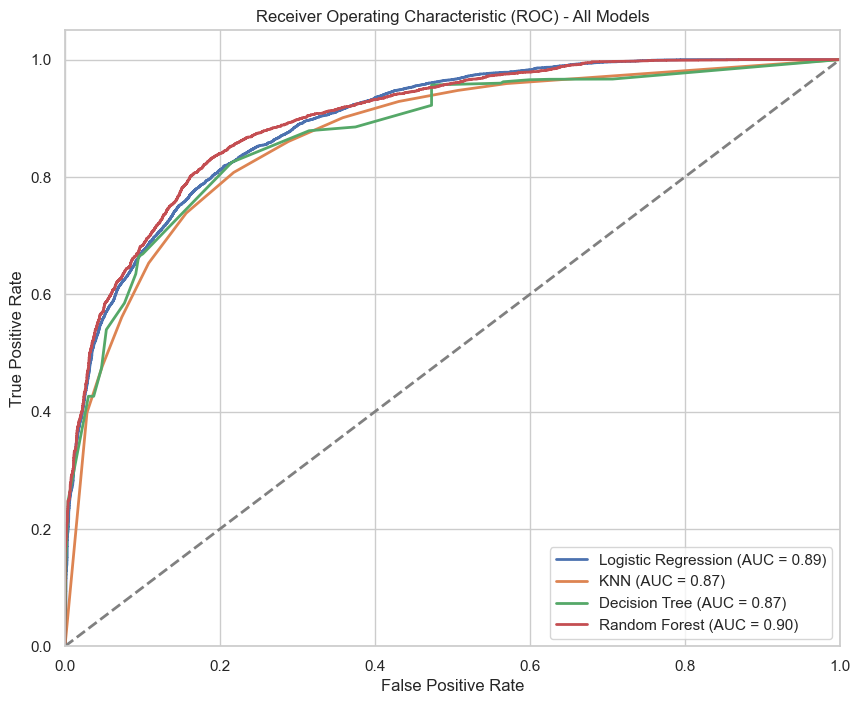

In [65]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define models and their predictions
models = {
    'Logistic Regression': best_lr_model,
    'KNN': best_knn_model,
    'Decision Tree': best_dt_model,
    'Random Forest': best_rf_model
}

# Plot the ROC curve for each model
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    # Get the predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random model)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - All Models')
plt.legend(loc="lower right")

# Show the plot
plt.show()


In [66]:
# Dictionary to store model results
model_results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors', 'Random Forest'],
    'Best Parameters': [
        grid_search_lr.best_params_,
        grid_search_dt.best_params_,
        grid_search_knn.best_params_,
        grid_search_rf.best_params_
    ],
    'Test Accuracy': [
        accuracy_lr,
        accuracy_dt,
        accuracy_knn,
        accuracy_rf
    ],
    'AUC-ROC': [
        auc_roc_lr,
        auc_roc_dt,
        auc_roc_knn,
        auc_roc_rf
    ]
}

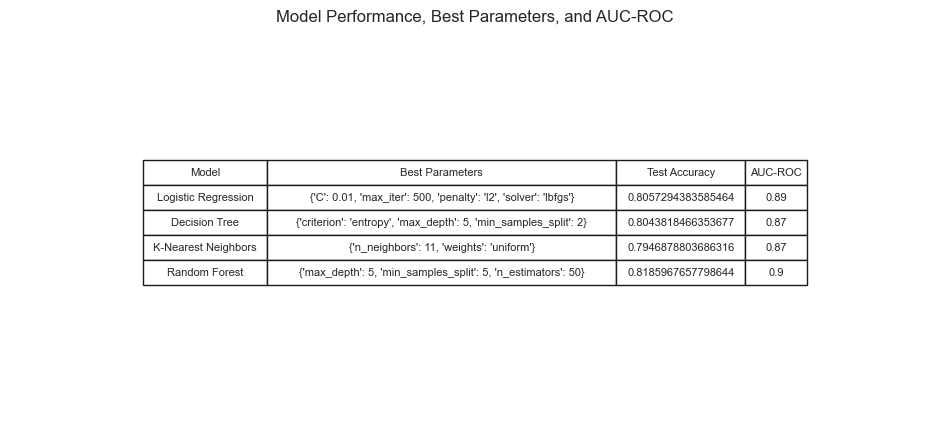

In [67]:
# Create DataFrame from the results dictionary
results_df = pd.DataFrame(model_results)

# Visualize the best parameters, test accuracies, and AUC-ROC in a table with adjusted column width
plt.figure(figsize=(12, 5))  # Increased figure width for more space
plt.axis('off')
table = plt.table(cellText=results_df.values,
                  colLabels=results_df.columns,
                  cellLoc='center',
                  loc='center')

# Adjust column width manually (for the 'Best Parameters' column)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)

# Increase width of 'Best Parameters' column by setting column width
table.auto_set_column_width([0, 1, 2, 3])  # This automatically adjusts the width for all columns

# Optional: Manually adjust width for 'Best Parameters' column by specifying widths for each column
# table.column(1).set_width(1.5)  # Example of manually adjusting width, feel free to tweak it

plt.title("Model Performance, Best Parameters, and AUC-ROC")
plt.show()


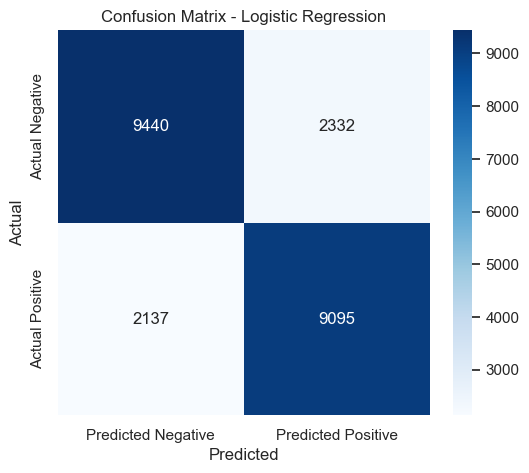

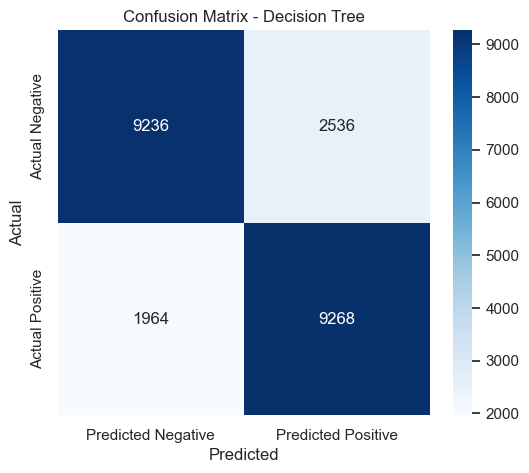

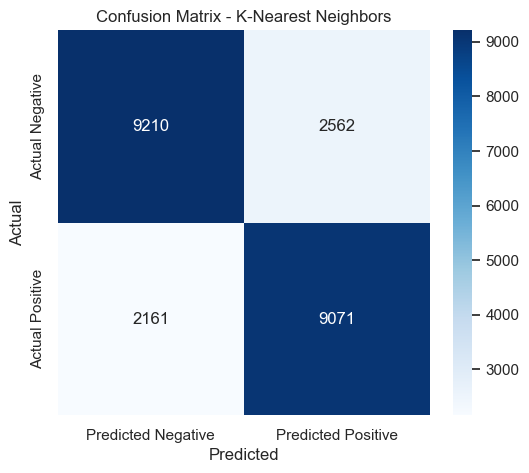

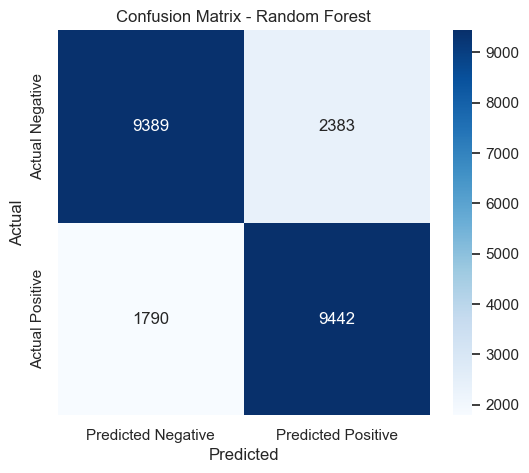

In [68]:
# Function to plot confusion matrix as heatmap
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression')
plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree')
plot_confusion_matrix(y_test, y_pred_knn, 'K-Nearest Neighbors')
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')

In [69]:
# Perform t-test on accuracy between models
accuracy_lr_knn_ttest = ttest_ind(lr_accuracies, knn_accuracies)
accuracy_lr_dt_ttest = ttest_ind(lr_accuracies, dt_accuracies)
accuracy_lr_rf_ttest = ttest_ind(lr_accuracies, rf_accuracies)

# Check p-values and interpret based on the null hypothesis
alpha = 0.05  # Significance level

# Logistic Regression vs KNN
if accuracy_lr_knn_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in accuracy between Logistic Regression and KNN.")
else:
    print("Fail to reject the null hypothesis: No significant difference in accuracy between Logistic Regression and KNN.")

# Logistic Regression vs Decision Tree
if accuracy_lr_dt_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in accuracy between Logistic Regression and Decision Tree.")
else:
    print("Fail to reject the null hypothesis: No significant difference in accuracy between Logistic Regression and Decision Tree.")

# Logistic Regression vs Random Forest
if accuracy_lr_rf_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in accuracy between Logistic Regression and Random Forest.")
else:
    print("Fail to reject the null hypothesis: No significant difference in accuracy between Logistic Regression and Random Forest.")


Reject the null hypothesis: There is a significant difference in accuracy between Logistic Regression and KNN.
Reject the null hypothesis: There is a significant difference in accuracy between Logistic Regression and Decision Tree.
Fail to reject the null hypothesis: No significant difference in accuracy between Logistic Regression and Random Forest.


In [70]:
# Perform t-test on F1 scores between models
f1_lr_knn_ttest = ttest_ind(lr_f1_scores, knn_f1_scores)
f1_lr_dt_ttest = ttest_ind(lr_f1_scores, dt_f1_scores)
f1_lr_rf_ttest = ttest_ind(lr_f1_scores, rf_f1_scores)

# Logistic Regression vs KNN F1 Score
if f1_lr_knn_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in F1 score between Logistic Regression and KNN.")
else:
    print("Fail to reject the null hypothesis: No significant difference in F1 score between Logistic Regression and KNN.")

# Logistic Regression vs Decision Tree F1 Score
if f1_lr_dt_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in F1 score between Logistic Regression and Decision Tree.")
else:
    print("Fail to reject the null hypothesis: No significant difference in F1 score between Logistic Regression and Decision Tree.")

# Logistic Regression vs Random Forest F1 Score
if f1_lr_rf_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in F1 score between Logistic Regression and Random Forest.")
else:
    print("Fail to reject the null hypothesis: No significant difference in F1 score between Logistic Regression and Random Forest.")



Reject the null hypothesis: There is a significant difference in F1 score between Logistic Regression and KNN.
Reject the null hypothesis: There is a significant difference in F1 score between Logistic Regression and Decision Tree.
Fail to reject the null hypothesis: No significant difference in F1 score between Logistic Regression and Random Forest.


In [71]:
# Perform t-test on AUC-ROC scores between models
auc_roc_lr_knn_ttest = ttest_ind(lr_auc_roc_scores, knn_auc_roc_scores)
auc_roc_lr_dt_ttest = ttest_ind(lr_auc_roc_scores, dt_auc_roc_scores)
auc_roc_lr_rf_ttest = ttest_ind(lr_auc_roc_scores, rf_auc_roc_scores)

# Logistic Regression vs KNN AUC-ROC
if auc_roc_lr_knn_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in AUC-ROC between Logistic Regression and KNN.")
else:
    print("Fail to reject the null hypothesis: No significant difference in AUC-ROC between Logistic Regression and KNN.")

# Logistic Regression vs Decision Tree AUC-ROC
if auc_roc_lr_dt_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in AUC-ROC between Logistic Regression and Decision Tree.")
else:
    print("Fail to reject the null hypothesis: No significant difference in AUC-ROC between Logistic Regression and Decision Tree.")

# Logistic Regression vs Random Forest AUC-ROC
if auc_roc_lr_rf_ttest.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference in AUC-ROC between Logistic Regression and Random Forest.")
else:
    print("Fail to reject the null hypothesis: No significant difference in AUC-ROC between Logistic Regression and Random Forest.")


Reject the null hypothesis: There is a significant difference in AUC-ROC between Logistic Regression and KNN.
Reject the null hypothesis: There is a significant difference in AUC-ROC between Logistic Regression and Decision Tree.
Fail to reject the null hypothesis: No significant difference in AUC-ROC between Logistic Regression and Random Forest.


In [72]:
lr_accuracies

array([0.72662425, 0.81665703, 0.78716021, 0.76094081, 0.76229034,
       0.77173703, 0.74918064, 0.69635628, 0.7854251 , 0.77597841])

In [73]:
knn_accuracies

array([0.69982649, 0.75149412, 0.72488915, 0.68690958, 0.72334683,
       0.68768074, 0.70291112, 0.67514941, 0.75727781, 0.76576056])

In [74]:
dt_accuracies

array([0.61557741, 0.73298631, 0.74339695, 0.69134374, 0.68208984,
       0.73838442, 0.68401774, 0.71351456, 0.71332177, 0.76711008])

In [75]:
rf_accuracies

array([0.71756314, 0.8264893 , 0.74937343, 0.72450357, 0.75053017,
       0.79024484, 0.71544245, 0.72161172, 0.76479661, 0.79140158])

In [76]:
accuracy_df = pd.DataFrame({
    'Logistic Regression': lr_accuracies,
    'KNN': knn_accuracies,
    'Decision Tree': dt_accuracies,
    'Random Forest': rf_accuracies
})

f1_score_df = pd.DataFrame({
    'Logistic Regression': lr_f1_scores,
    'KNN': knn_f1_scores,
    'Decision Tree': dt_f1_scores,
    'Random Forest': rf_f1_scores
})

auc_roc_df = pd.DataFrame({
    'Logistic Regression': lr_auc_roc_scores,
    'KNN': knn_auc_roc_scores,
    'Decision Tree': dt_auc_roc_scores,
    'Random Forest': rf_auc_roc_scores
})

# Print the tables
print("Accuracy Scores Table:")
print(accuracy_df)
print("\nF1 Scores Table:")
print(f1_score_df)
print("\nAUC-ROC Scores Table:")
print(auc_roc_df)

Accuracy Scores Table:
   Logistic Regression       KNN  Decision Tree  Random Forest
0             0.726624  0.699826       0.615577       0.717563
1             0.816657  0.751494       0.732986       0.826489
2             0.787160  0.724889       0.743397       0.749373
3             0.760941  0.686910       0.691344       0.724504
4             0.762290  0.723347       0.682090       0.750530
5             0.771737  0.687681       0.738384       0.790245
6             0.749181  0.702911       0.684018       0.715442
7             0.696356  0.675149       0.713515       0.721612
8             0.785425  0.757278       0.713322       0.764797
9             0.775978  0.765761       0.767110       0.791402

F1 Scores Table:
   Logistic Regression       KNN  Decision Tree  Random Forest
0             0.729596  0.714050       0.600881       0.732127
1             0.812463  0.750918       0.742517       0.824630
2             0.824148  0.769950       0.791216       0.784125
3             

In [77]:
# Print the tables
print("Accuracy Scores Table:")
print(accuracy_df)

Accuracy Scores Table:
   Logistic Regression       KNN  Decision Tree  Random Forest
0             0.726624  0.699826       0.615577       0.717563
1             0.816657  0.751494       0.732986       0.826489
2             0.787160  0.724889       0.743397       0.749373
3             0.760941  0.686910       0.691344       0.724504
4             0.762290  0.723347       0.682090       0.750530
5             0.771737  0.687681       0.738384       0.790245
6             0.749181  0.702911       0.684018       0.715442
7             0.696356  0.675149       0.713515       0.721612
8             0.785425  0.757278       0.713322       0.764797
9             0.775978  0.765761       0.767110       0.791402


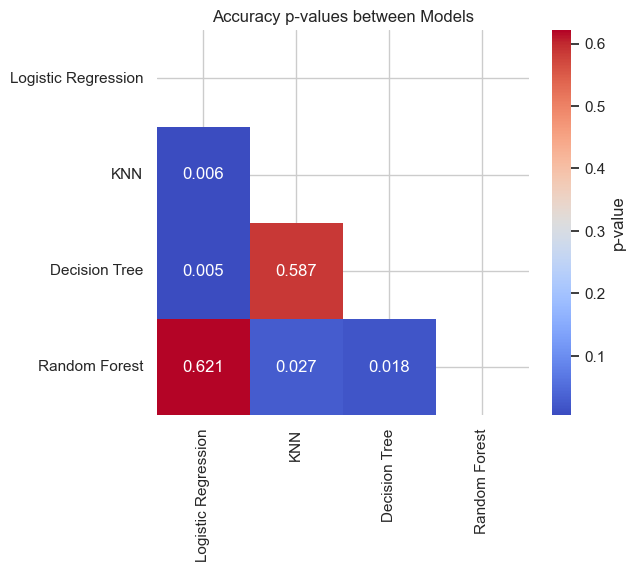

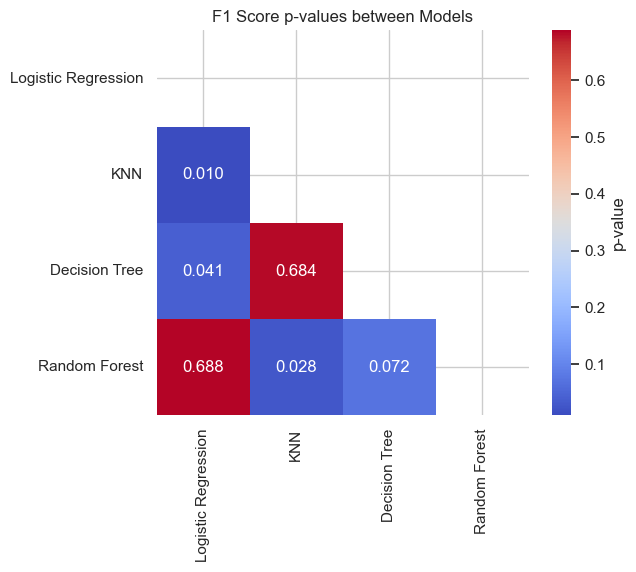

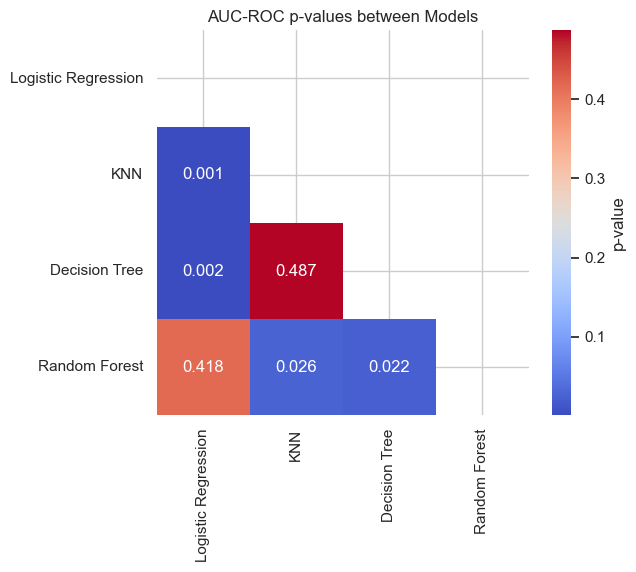

In [78]:
# Define alpha level
alpha = 0.05


# Models names
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']

# Perform t-tests and create p-value matrices
def get_pvalue_matrix(score_list):
    pvalues = np.zeros((4, 4))
    for i in range(4):
        for j in range(i):
            t_stat, pvalue = ttest_ind(score_list[i], score_list[j])
            pvalues[i, j] = pvalue
    return pvalues

# Collect scores into lists for easy iteration
accuracy_scores = [lr_accuracies, knn_accuracies, dt_accuracies, rf_accuracies]
f1_scores = [lr_f1_scores, knn_f1_scores, dt_f1_scores, rf_f1_scores]
auc_roc_scores = [lr_auc_roc_scores, knn_auc_roc_scores, dt_auc_roc_scores, rf_auc_roc_scores]

# Calculate p-value matrices
accuracy_pvalues = get_pvalue_matrix(accuracy_scores)
f1_pvalues = get_pvalue_matrix(f1_scores)
auc_roc_pvalues = get_pvalue_matrix(auc_roc_scores)

# Function to plot heatmaps with only lower triangle
def plot_heatmap(pvalues, title):
    mask = np.triu(np.ones_like(pvalues, dtype=bool))  # mask upper triangle
    plt.figure(figsize=(6, 5))
    sns.heatmap(pvalues, annot=True, fmt=".3f", cmap="coolwarm", mask=mask, 
                xticklabels=models, yticklabels=models, cbar_kws={'label': 'p-value'})
    plt.title(title)
    plt.show()

# Plot heatmaps for each metric
plot_heatmap(accuracy_pvalues, 'Accuracy p-values between Models')
plot_heatmap(f1_pvalues, 'F1 Score p-values between Models')
plot_heatmap(auc_roc_pvalues, 'AUC-ROC p-values between Models')


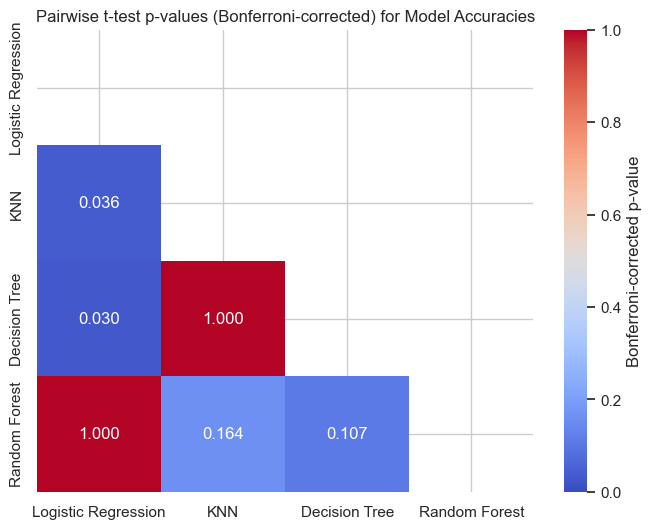

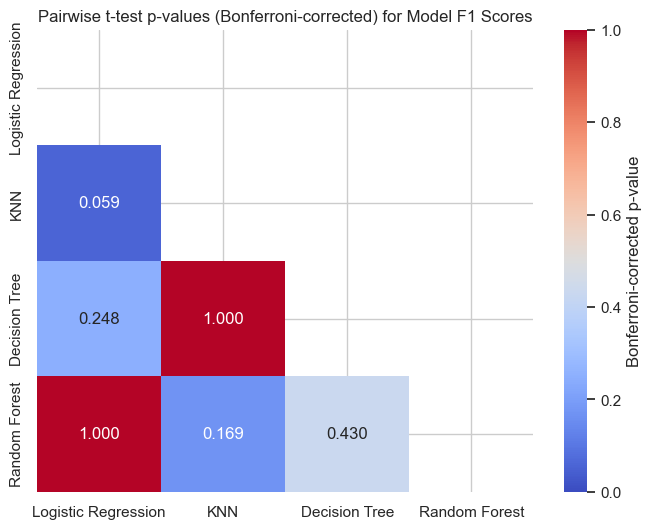

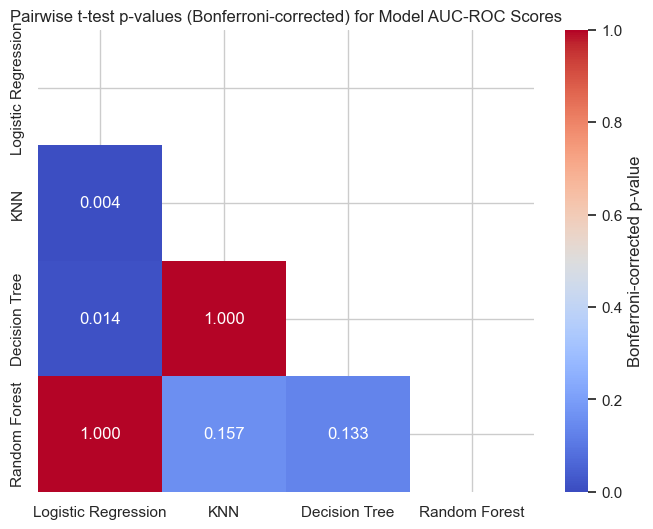

In [79]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Assuming your data frames for accuracy, F1 score, and AUC-ROC scores are already created:
# accuracy_df, f1_score_df, auc_roc_df

# Model names
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']

# Function to create pairwise t-test p-value matrix with Bonferroni correction
def create_p_value_matrix(score_df):
    """Compute the pairwise t-test p-values matrix with Bonferroni correction."""
    num_models = score_df.shape[1]
    p_matrix = np.ones((num_models, num_models))  # Initialize with 1s

    # Compute pairwise t-test p-values
    for i in range(num_models):
        for j in range(i + 1, num_models):
            _, p_val = ttest_ind(score_df.iloc[:, i], score_df.iloc[:, j])
            p_matrix[i, j] = p_val
            p_matrix[j, i] = p_val  # Mirror the matrix

    # Apply Bonferroni correction on the upper triangle of the matrix
    _, corrected_p_values, _, _ = multipletests(p_matrix[np.triu_indices_from(p_matrix, k=1)], method="bonferroni")
    p_matrix[np.triu_indices_from(p_matrix, k=1)] = corrected_p_values
    p_matrix[np.tril_indices_from(p_matrix, k=-1)] = corrected_p_values  # Fill lower triangle too

    return p_matrix

# Generate p-value matrices for accuracy, F1 score, and AUC-ROC
accuracy_p_matrix = create_p_value_matrix(accuracy_df)
f1_p_matrix = create_p_value_matrix(f1_score_df)
auc_roc_p_matrix = create_p_value_matrix(auc_roc_df)

# Function to plot lower triangle of p-value matrix
def plot_lower_triangle_heatmap(p_matrix, title):
    """Plot only the lower triangle of the heatmap."""
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(p_matrix, dtype=bool))

    # Create heatmap with the mask applied
    plt.figure(figsize=(8, 6))
    sns.heatmap(p_matrix, annot=True, fmt=".3f", cmap="coolwarm", xticklabels=model_names, yticklabels=model_names,
                mask=mask, cbar_kws={'label': 'Bonferroni-corrected p-value'}, vmin=0, vmax=1)
    plt.title(title)
    plt.show()

# Plot heatmaps for Accuracy, F1 Score, and AUC-ROC with only the lower triangle displayed
plot_lower_triangle_heatmap(accuracy_p_matrix, "Pairwise t-test p-values (Bonferroni-corrected) for Model Accuracies")
plot_lower_triangle_heatmap(f1_p_matrix, "Pairwise t-test p-values (Bonferroni-corrected) for Model F1 Scores")
plot_lower_triangle_heatmap(auc_roc_p_matrix, "Pairwise t-test p-values (Bonferroni-corrected) for Model AUC-ROC Scores")


In [80]:
print(accuracy_pvalues, 'Accuracy p-values between Models')
print(f1_pvalues, 'F1 Score p-values between Models')
print(auc_roc_pvalues, 'AUC-ROC p-values between Models')

[[0.         0.         0.         0.        ]
 [0.00607435 0.         0.         0.        ]
 [0.00492542 0.58698005 0.         0.        ]
 [0.62118519 0.02731174 0.01779549 0.        ]] Accuracy p-values between Models
[[0.         0.         0.         0.        ]
 [0.00976031 0.         0.         0.        ]
 [0.04127607 0.68421497 0.         0.        ]
 [0.68801209 0.02815829 0.07167712 0.        ]] F1 Score p-values between Models
[[0.         0.         0.         0.        ]
 [0.00070507 0.         0.         0.        ]
 [0.00239757 0.48707113 0.         0.        ]
 [0.41819878 0.02617715 0.02212971 0.        ]] AUC-ROC p-values between Models


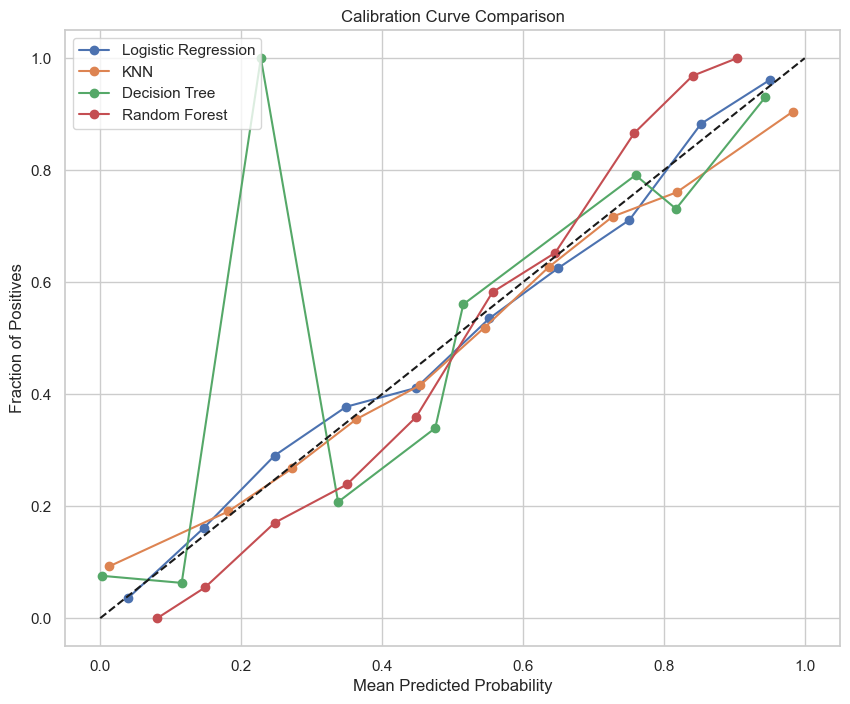

In [81]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

models = {
    'Logistic Regression': best_lr_model,  # Replace `lr_model` with your trained logistic regression model
    'KNN': best_knn_model,                # Replace `knn_model` with your trained KNN model
    'Decision Tree': best_dt_model,       # Replace `dt_model` with your trained decision tree model
    'Random Forest': best_rf_model        # Replace `rf_model` with your trained random forest model
}

plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'{model_name}')

plt.plot([0, 1], [0, 1], 'k--')  # Perfectly calibrated line
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve Comparison')
plt.legend(loc='upper left')
plt.show()


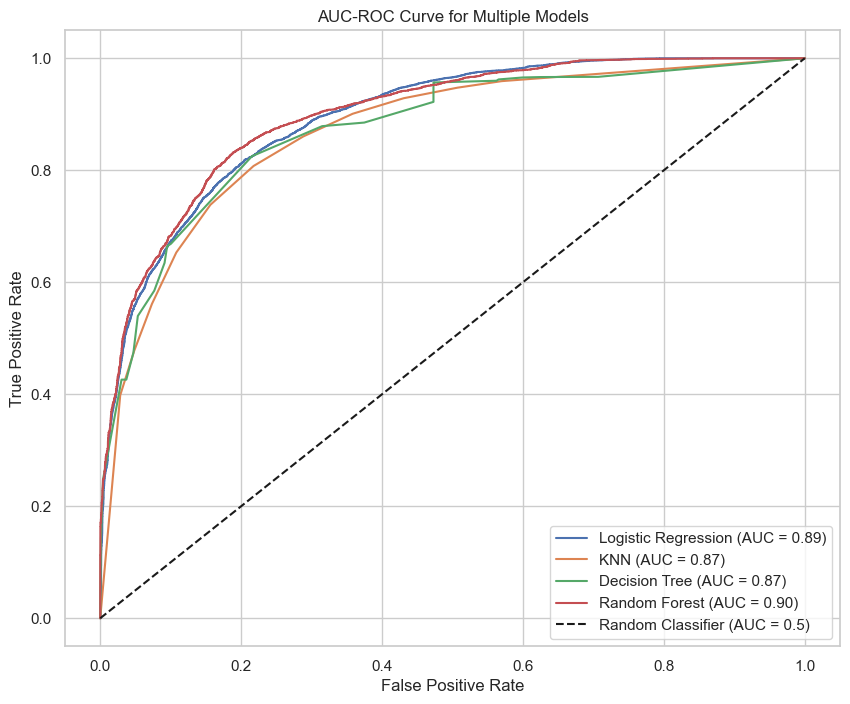

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Create a figure for the AUC-ROC curve
plt.figure(figsize=(10, 8))

# Loop through each model and plot its AUC-ROC curve
for model_name, model in models.items():
    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]  # Use the second column (positive class)

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Compute the AUC score
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for this model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for Multiple Models')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [83]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

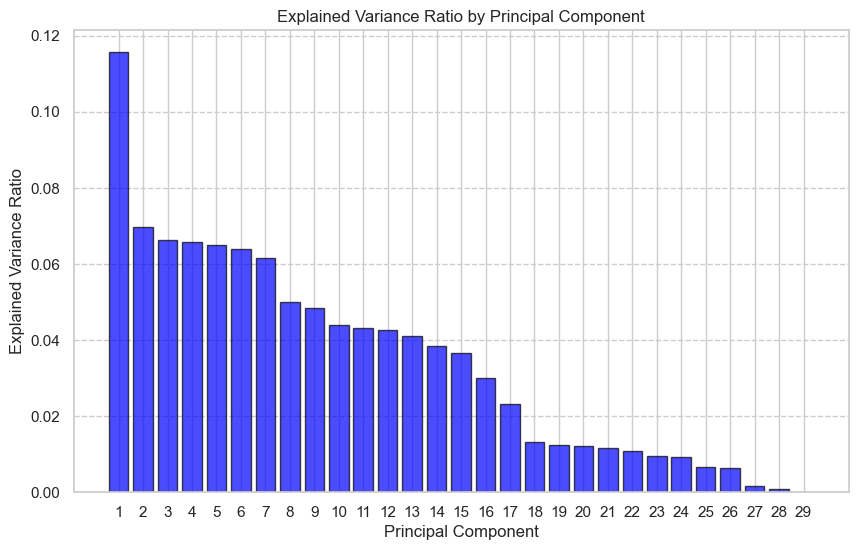

In [84]:
# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(axis='y', linestyle='--')
plt.show()

In [85]:
# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:",cumulative_variance)

Cumulative Explained Variance: [0.11566331 0.1852935  0.25167059 0.31737054 0.3822756  0.44624036
 0.50785619 0.55789898 0.60630139 0.6502763  0.69340746 0.73596445
 0.77708759 0.815577   0.85223153 0.88226659 0.90538728 0.91869771
 0.93112614 0.94335541 0.95485422 0.96577648 0.97533414 0.9844718
 0.99098092 0.99736845 0.99903894 1.         1.        ]


In [86]:
# Number of components to explain at least 90% variance
n_components_90_variance = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components that explain at least 90% variance: {n_components_90_variance}")

Number of components that explain at least 90% variance: 17


In [61]:
X_train_1

batting_team           bowling_team  \
124     Royal Challengers Bangalore  Kolkata Knight Riders   
125     Royal Challengers Bangalore  Kolkata Knight Riders   
126     Royal Challengers Bangalore  Kolkata Knight Riders   
127     Royal Challengers Bangalore  Kolkata Knight Riders   
128     Royal Challengers Bangalore  Kolkata Knight Riders   
...                             ...                    ...   
158687               Mumbai Indians         Delhi Capitals   
158688               Mumbai Indians         Delhi Capitals   
158689               Mumbai Indians         Delhi Capitals   
158690               Mumbai Indians         Delhi Capitals   
158691               Mumbai Indians         Delhi Capitals   

                        toss_winner toss_decision  ball_left  wicket_left  \
124     Royal Challengers Bangalore         field        119           10   
125     Royal Challengers Bangalore         field        118           10   
126     Royal Challengers Bangalore         field        117           10   
127     Royal Challengers Bangalore         field        116           10   
128     Royal Challengers Bangalore         field        115           10   
...                             ...           ...        ...          ...   
158687               Delhi Capitals           bat         12            6   
158688               Delhi Capitals           bat         11            6   
158689               Delhi Capitals           bat         10            6   
158690               Delhi Capitals           bat          9            5   
158691               Delhi Capitals           bat          8            5   

        first_inning_run  current_runs  run_left       crr        rrr  
124                  222             1       221  6.000000  11.142857  
125                  222             2       220  6.000000  11.186441  
126                  222             2       220  4.000000  11.282051  
127                  222             3       219  4.500000  11.327586  
128                  222             4       218  4.800000  11.373913  
...                  ...           ...       ...       ...        ...  
158687               156           154         2  8.555556   1.000000  
158688               156           155         1  8.532110   0.545455  
158689               156           156         0  8.509091   0.000000  
158690               156           156         0  8.432432   0.000000  
158691               156           157        -1  8.410714  -0.750000  

[57062 rows x 11 columns]

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

def train_logistic_regression(X_train, y_train):
    
    # Define ColumnTransformer for categorical features
    trf = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), ['batting_team', 'bowling_team', 'toss_winner', 'toss_decision'])
        ], 
        remainder='passthrough'
    )
    
    # Transform X_train
    X_train_final = trf.fit_transform(X_train)
    
    # Train the logistic regression model
    #model = LogisticRegression()
    best_lr_model.fit(X_train_final, y_train)
    
    return best_lr_model, trf

def predict_probability(model, trf, data):
   
    # Convert data to a DataFrame format with a single row
    data = pd.DataFrame([data])
    data['run_left']=data['first_inning_run']-data['current_runs']
    data['crr']=(data['current_runs']*6)/(120-data['ball_left'])
    data['rrr']=(data['run_left']*6)/data['ball_left']
    

    
    # Transform data using the trained transformer
    data_final = trf.transform(data)
    
    # Predict probability for class 1
    probability = model.predict_proba(data_final)[:, 1][0]
    
    return probability

In [68]:
model, trf = train_logistic_regression(X_train_1, y_train)

C:\Users\Kundan Mourya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
single_data = {
    'batting_team': 'Chennai Super Kings',
    'bowling_team': 'Royal Challengers Bangalore',
    'toss_winner': 'Royal Challengers Bangalore',
    'toss_decision': 'field',
    'ball_left': 30,
    'wicket_left':7,
    'first_inning_run': 207,
    'current_runs': 180
}


probability = predict_probability(model, trf, single_data)
print("Probability of winning of batting team:", probability)

Probability of winning of batting team: 0.953946129150985


In [72]:
import pickle
with open('best_logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(best_lr_model, model_file)

In [73]:
with open('best_logistic_regression_model.pkl', 'wb') as model_file:
        pickle.dump(best_lr_model, model_file)

In [74]:
with open('transformer.pkl', 'wb') as transformer_file:
        pickle.dump(trf, transformer_file)